In [90]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import time

# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Initial Processing

In [2]:
# Set your own path
path = 'data/CA_final.csv'

df = pd.read_csv(path)
df.head()

In [4]:
len(df)

1741433

We've got 1.7M accident records in CA.

In [5]:
df.groupby('Year')['ID'].size()

Year
2016    140452
2017    152748
2018    156898
2019    213455
2020    285532
2021    341876
2022    375913
2023     74559
Name: ID, dtype: int64

In [7]:
df_2022 = df[df['Year'] == 2022]
df_2022.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Hour,Minute,Wind_Speed(mph)_Imputed,Humidity(%)_Imputed,Temperature(F)_Imputed,Visibility(mi)_Imputed,Pressure(in)_Imputed,geohash4,Wind_Direction_Imputed,Weather_Condition_Imputed
175167,A-512231,Source2,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,NaN,NaN,0.0,...,2,2,6.0,28.0,86.0,10.0,27.35,9qhh,E,Thunderstorms and Rain
175168,A-512257,Source2,1,2022-09-08 02:02:58,2022-09-08 02:32:20,34.177322,-118.877014,NaN,NaN,0.0,...,2,2,3.0,87.0,68.0,9.0,29.78,9q56,WNW,Thunderstorms and Rain
175169,A-512277,Source2,3,2022-09-07 21:54:19,2022-09-07 22:38:20,38.593945,-121.504059,NaN,NaN,0.0,...,21,54,0.0,28.0,83.0,10.0,29.83,9qce,VAR,Thunderstorms and Rain
175170,A-512340,Source2,2,2022-09-08 02:03:43,2022-09-08 02:33:13,33.850147,-117.875938,NaN,NaN,0.0,...,2,3,0.0,66.0,79.0,10.0,29.76,9qh0,VAR,Thunderstorms and Rain
175171,A-512341,Source3,1,2022-09-08 02:30:59,2022-09-08 03:00:27,33.884056,-118.029007,NaN,NaN,0.0,...,2,30,0.0,66.0,78.0,10.0,29.74,9qh0,VAR,Thunderstorms and Rain


In [8]:
df_2022['Start_Time'].min(), df_2022['Start_Time'].max()

('2022-01-01 00:02:00', '2022-12-31 23:59:00')

In [11]:
# Saving data for 2022 to lighten memory.
save_path = 'data/data_2022'
df_2022.to_csv(save_path)

If you have already saved data for 2022 start here

In [3]:
# Load 2022 data
load_path = 'data/data_2022'
df = pd.read_csv(load_path)

In [4]:
len(df)

375913

In [16]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

In [5]:
# Creating a time range with index representing consecutive hours in 2022
start_time = pd.Timestamp('2022-01-01 00:00:00')
end_time = pd.Timestamp('2022-12-31 23:00:00')
hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')
hourly_df = pd.DataFrame(hourly_range, columns=['hour'])
hourly_df['hour_index'] = range(1, len(hourly_range) + 1)


C:\Users\balda\AppData\Local\Temp\ipykernel_20292\2312101316.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')


In [6]:
hourly_df.head()

,hour,hour_index
0,2022-01-01 00:00:00,1
1,2022-01-01 01:00:00,2
2,2022-01-01 02:00:00,3
3,2022-01-01 03:00:00,4
4,2022-01-01 04:00:00,5


In [24]:
len(hourly_df)

8760

In [7]:
geohashes = df['geohash5'].unique()
multi_index = pd.MultiIndex.from_product([hourly_range, geohashes], names=['hour', 'geohash5'])
multi_index_df = pd.DataFrame(index=multi_index).reset_index()

In [8]:
multi_index_df.head()

,hour,geohash5
0,2022-01-01,9qhh7
1,2022-01-01,9q56q
2,2022-01-01,9qcee
3,2022-01-01,9qh0t
4,2022-01-01,9qh0f


In [57]:
# Step 6: Count accidents per hour and geohash
accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')

# Step 7: Merge the multi-index DataFrame with the accident counts
merged_df = pd.merge(multi_index_df, accident_counts, how='left', left_on=['hour', 'geohash5'], right_on=['Start_Time', 'geohash5'])

C:\Users\balda\AppData\Local\Temp\ipykernel_20292\3631858385.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')


Let's add one_hot_encoded features for hour of the day and day of the week.

In [58]:
merged_df = merged_df.drop(columns=['Start_Time']).fillna(value=0)

# Assuming 'df' is your DataFrame with the structure you provided
# If not already in datetime format, ensure 'hour' is in datetime format
merged_df['hour'] = pd.to_datetime(merged_df['hour'])

# Step 1: Extract hour of the day and day of the week
merged_df['hour_of_day'] = merged_df['hour'].dt.hour
merged_df['day_of_week'] = merged_df['hour'].dt.dayofweek  # Monday=0, Sunday=6

# Step 2: Generate one-hot encoded columns
hour_dummies = pd.get_dummies(merged_df['hour_of_day'], prefix='hour')
day_dummies = pd.get_dummies(merged_df['day_of_week'], prefix='day')

# Step 3: Concatenate these new columns to the original DataFrame
merged_df = pd.concat([merged_df, hour_dummies, day_dummies], axis=1)

# Display the final DataFrame
print(merged_df)

                        hour geohash5  accident_count  hour_of_day  \
0        2022-01-01 00:00:00    9qhh7             0.0            0   
1        2022-01-01 00:00:00    9q56q             1.0            0   
2        2022-01-01 00:00:00    9qcee             0.0            0   
3        2022-01-01 00:00:00    9qh0t             0.0            0   
4        2022-01-01 00:00:00    9qh0f             0.0            0   
...                      ...      ...             ...          ...   
63448675 2022-12-31 23:00:00    9r4rr             0.0           23   
63448676 2022-12-31 23:00:00    9r354             0.0           23   
63448677 2022-12-31 23:00:00    9r3q8             0.0           23   
63448678 2022-12-31 23:00:00    9r4n7             0.0           23   
63448679 2022-12-31 23:00:00    9r0wf             0.0           23   

          day_of_week  hour_0  hour_1  hour_2  hour_3  hour_4  ...  hour_21  \
0                   5    True   False   False   False   False  ...    False   
1

There's a lot of hashes and a lot of hours so let's take just one hash for now and try to model it. Going for hash `9q5cw` - one with the most accidents in 2022.

In [59]:
one_hash_df = merged_df[merged_df['geohash5'] == '9q5cw']

In [60]:
one_hash_df

,hour,geohash5,accident_count,hour_of_day,day_of_week,hour_0,hour_1,hour_2,hour_3,hour_4,...,hour_21,hour_22,hour_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6
116,2022-01-01 00:00:00,9q5cw,0.0,0,5,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7359,2022-01-01 01:00:00,9q5cw,0.0,1,5,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
14602,2022-01-01 02:00:00,9q5cw,0.0,2,5,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
21845,2022-01-01 03:00:00,9q5cw,2.0,3,5,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
29088,2022-01-01 04:00:00,9q5cw,0.0,4,5,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63412581,2022-12-31 19:00:00,9q5cw,4.0,19,5,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
63419824,2022-12-31 20:00:00,9q5cw,3.0,20,5,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
63427067,2022-12-31 21:00:00,9q5cw,0.0,21,5,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
63434310,2022-12-31 22:00:00,9q5cw,7.0,22,5,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False


## 2. Training

The code I am using here is from exercise 06 Part 2.

In [83]:
# Define target
y = np.array(one_hash_df['accident_count'])
X = np.array(one_hash_df.drop(columns=['hour', 'geohash5', 'accident_count', 'hour_of_day', 'day_of_week']))

# Split into train and test
N = len(X)
split_idx = int(0.8*N)
X_train = X[:split_idx,:]
y_train = y[:split_idx]
X_test = X[split_idx:,:]
y_test = y[split_idx:]

print(' X_train:', X_train.shape, '\n', 'X_test:', X_test.shape, '\n', 'y_train:', y_train.shape, '\n', 'y_test:', y_test.shape)

 X_train: (7008, 33) 
 X_test: (1752, 33) 
 y_train: (7008,) 
 y_test: (1752,)


Following exercises let's try a simple autoregressive model of order 2, AR(2), of the form:

\begin{align}
z_t &\sim \mathcal{N}(\beta_1 z_{t-1}, \tau^2)\\
y_t &\sim \mathcal{N}(z_t, \sigma^2)
\end{align}

In [117]:
def f_without_noise(carry, x=None):
  beta1, beta2, z_prev1, z_prev2 = carry
  z_t = beta1*z_prev1 + beta2*z_prev2
  z_prev2 = z_prev1
  z_prev1 = z_t
  return (beta1, beta2, z_prev1, z_prev2), z_t

In [118]:
beta1 = beta2 = 1.
z_prev1 = z_prev2 = 1.
carry = (beta1, beta2, z_prev1, z_prev2)
carry_updated, z_t = f_without_noise(carry, x=None) # propagating the dynamics forward for 1 time step
print("Initial carried items: \nbeta1: {}, beta2: {}, z_prev1: {}, z_prev2: {}".format(carry[0], carry[1], carry[2], carry[3]))
print("Updated carried items: \nbeta1: {}, beta2: {}, z_prev1: {}, z_prev2: {}".format(carry_updated[0], carry_updated[1], carry_updated[2], carry_updated[3]))
print("Computed z_t: {}".format(z_t))

Initial carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 1.0, z_prev2: 1.0
Updated carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 2.0, z_prev2: 1.0
Computed z_t: 2.0


In [119]:
beta1 = beta2 = 1.
z_prev1 = z_prev2 = 1.
carry = (beta1, beta2, z_prev1, z_prev2)
carry_updated, z_collection = jax.lax.scan(f=f_without_noise, init=carry, xs=None, length=5) # propagating the dynamics forward for 5 time steps
print("Initial carried items: \nbeta1: {}, beta2: {}, z_prev1: {}, z_prev2: {}".format(carry[0], carry[1], carry[2], carry[3]))
print("Final carried items: \nbeta1: {}, beta2: {}, z_prev1: {}, z_prev2: {}".format(carry_updated[0], carry_updated[1], carry_updated[2], carry_updated[3]))
print("Computed z_t (for t=1,...,5):")
for t in range(5):
  print("z{}={}".format(str(t+1), z_collection[t]))

Initial carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 1.0, z_prev2: 1.0
Final carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 13.0, z_prev2: 8.0
Computed z_t (for t=1,...,5):
z1=2.0
z2=3.0
z3=5.0
z4=8.0
z5=13.0


In [120]:
def f(carry, noise_t):
  beta1, beta2, z_prev1, z_prev2, tau = carry
  z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
  z_prev2 = z_prev1
  z_prev1 = z_t
  return (beta1, beta2, z_prev1, z_prev2, tau), z_t

In [121]:
def model(T, T_forecast, obs=None):
    """ Define priors over beta1, beta2, tau, noises, sigma, z_prev1 and z_prev2 (keep the shapes in mind)
    # Your code here
    """
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=5.))
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=5.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=3.))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0., scale=3.))
    z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0., scale=3.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    # Your code here
    """
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_pred) - note that you don't need a pyro.plate!
    # Your code here
    """
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs[:T])
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

In [127]:
N_train = len(X_train)
N_test = len(X_test)
print('N_test', N_test)

t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=7000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs=y_train[:])

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

N_test 1752


sample: 100%|██████████| 8000/8000 [07:29<00:00, 17.79it/s, 1 steps of size 5.00e-03. acc. prob=0.00]  


Total time: 7.535m


In [128]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta_1      1.12      0.00      1.12      1.12      1.12     14.17      1.10
      beta_2     -0.12      0.00     -0.12     -0.12     -0.12     13.61      1.11
   noises[0]     -1.19      0.00     -1.19     -1.19     -1.19      7.61      1.01
   noises[1]     -0.03      0.00     -0.03     -0.03     -0.03      2.78      2.13
   noises[2]      1.17      0.00      1.17      1.17      1.17      4.30      1.08
   noises[3]      0.06      0.00      0.06      0.06      0.06      2.97      1.97
   noises[4]      0.71      0.00      0.71      0.71      0.71      6.05      1.05
   noises[5]     -0.05      0.00     -0.05     -0.05     -0.05      3.28      1.67
   noises[6]      0.91      0.00      0.91      0.91      0.91      4.14      1.12
   noises[7]     -1.88      0.00     -1.88     -1.88     -1.88      3.78      1.01
   noises[8]     -0.54      0.00     -0.54     -0.54     -0.54      5.16      1.51
   

In [129]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

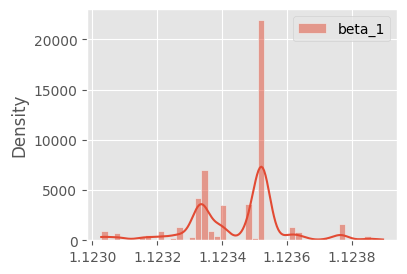

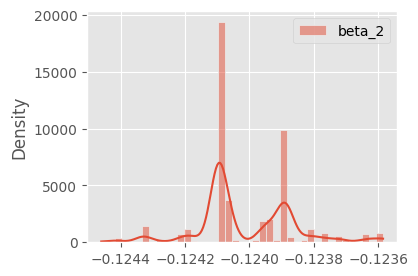

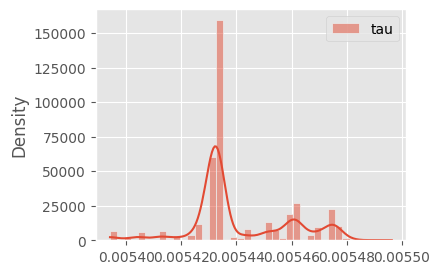

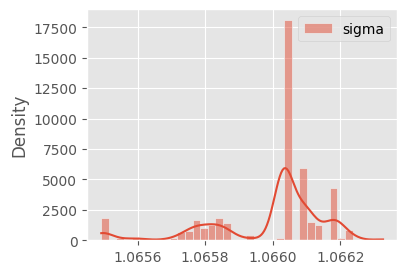

In [130]:
nodes = ["beta_1", "beta_2", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
  plt.legend()
  plt.show()

In [131]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

In [133]:
ix_train = range(0, 7008)
ix_test = range(7008, 8760)

In [132]:
len(q_mean)

1752

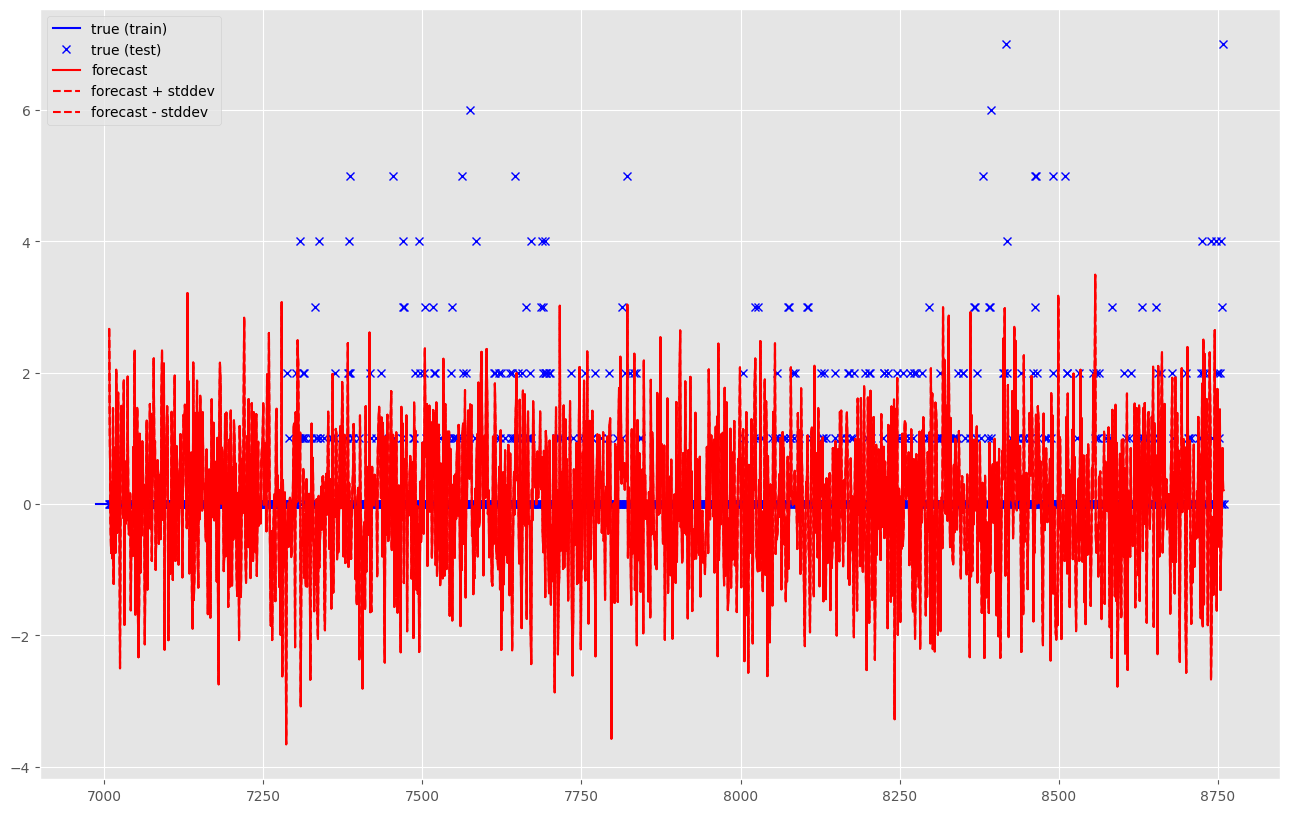

In [134]:
plt.plot(ix_train[-20:], y_train[-20:], "b-")
plt.plot(ix_test, y_test[:], "bx")
plt.plot(ix_test, y_pred_mean, "r-")
plt.plot(ix_test, y_pred_025, "r--")
plt.plot(ix_test, y_pred_975, "r--")
plt.fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()